In [111]:
import argparse
from datetime import datetime, date
from uti import DataLoader, Logger
from Database import GSDatabase, GSPriceDf
import re
from Model.settings import DataCleaner
import pandas as pd
import numpy as np
from datetime import datetime, date
from Backtest.settings import get_expectancy
from library import Dataset

GSD = GSDatabase()
logger = Logger()
DL = DataLoader()
DC = DataCleaner()
import matplotlib.pyplot as plt
from Broker import get_pnl

In [ ]:
"""
1. Get train data before march, used as the scoring training data on reports after march

2. Pull the reports after march, 
- Apply before march scoring on march reports
- Apply before april scoring on april reports
- Apply scoring for Goldman and Citi

3. From "Jay pnl for benchmark.csv", calculate the number of longs/shorts on each day; real trades pnl, times ATR(x) to reach the 
pnl as is the case where ATR(x)=1 is used in system calculation

4. Select trades from Goldman/Citi based on daily numbers of shorts/longs
Three cases to consider
- Wholly Goldman
- Wholly Citi
- Randomly from Goldman/Citi

"""

In [12]:
jay_pnl = DL.loadDB('Jay pnl for benchmark.csv', parse_dates=['Entry Date', 'Exit Date'])
jay_pnl['side'] = jay_pnl['Side']
jay_pnl['No. of trades'] = 1

17:11:42 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Jay pnl for benchmark.csv


In [37]:
jay_pnl['Region'] = jay_pnl['Ticker'].str.split(' ').apply(lambda x: x[1])
jay_pnl['Region']
DS = Dataset(jay_pnl)
DS._add_exch_location_col(mode='eikon')
DS._add_exch_region_col()
jay_pnl = DS.df.copy(deep=True)

0      SM
1      LN
2      NA
3      NA
4      SM
       ..
257    JP
258    SS
259    LN
260    SW
261    SW
Name: Region, Length: 262, dtype: object

In [122]:
jay_pnl['d0_r'] = jay_pnl['Realized R']

In [43]:
trade_record = jay_pnl.groupby(['Entry Date', 'exch_region', 'Side']).agg({'No. of trades': lambda x: x.sum()})
trade_record

In [58]:
citi_reports = DL.loadDB('Citi system reports.csv', parse_dates=['Date', 'Time'])
gs_reports = DL.loadDB('Goldman system reports.csv', parse_dates=['Date', 'Time'])

18:08:23 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Citi system reports.csv
18:08:23 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Goldman system reports.csv


In [59]:
all_reports = pd.concat([citi_reports[gs_reports.columns], gs_reports], axis=0).reset_index(drop=True)

In [94]:
# 1. Combined scoring: Combined score ranking
system_report_ind = []
for i, row in trade_record.iterrows():
    
    num_trade = row['No. of trades']
    (date, region, side) = i
    df = all_reports[all_reports['Date'] == date]
    df = df[df['exch_region'] == region]
    df = df[df['side'] == side]
    df = df.sort_values('d0_exp', ascending=False)
    
    system_report_ind.extend(df.iloc[:num_trade].index)
system_reports = all_reports.iloc[system_report_ind]
system_reports = system_reports.sort_values(['Date'], ascending=True).reset_index(drop=True)
system_reports

system_reports = get_pnl(system_reports)

(Timestamp('2022-03-01 00:00:00'), 'Asia', 'short') 1
[98]
(Timestamp('2022-03-01 00:00:00'), 'Europe', 'long') 2
[98, 9, 106]
(Timestamp('2022-03-02 00:00:00'), 'Asia', 'short') 1
[98, 9, 106, 269]
(Timestamp('2022-03-02 00:00:00'), 'Europe', 'long') 2
[98, 9, 106, 269, 214, 290]
(Timestamp('2022-03-02 00:00:00'), 'Europe', 'short') 1
[98, 9, 106, 269, 214, 290, 212]
(Timestamp('2022-03-03 00:00:00'), 'Asia', 'short') 1
[98, 9, 106, 269, 214, 290, 212, 323]
(Timestamp('2022-03-03 00:00:00'), 'Europe', 'long') 2
[98, 9, 106, 269, 214, 290, 212, 323, 331, 335]
(Timestamp('2022-03-03 00:00:00'), 'Europe', 'short') 3
[98, 9, 106, 269, 214, 290, 212, 323, 331, 335, 327, 328, 330]
(Timestamp('2022-03-04 00:00:00'), 'Asia', 'short') 1
[98, 9, 106, 269, 214, 290, 212, 323, 331, 335, 327, 328, 330, 534]
(Timestamp('2022-03-04 00:00:00'), 'Europe', 'long') 2
[98, 9, 106, 269, 214, 290, 212, 323, 331, 335, 327, 328, 330, 534, 573, 571]
(Timestamp('2022-03-04 00:00:00'), 'Europe', 'short') 2
[98,

(Timestamp('2022-04-11 00:00:00'), 'Europe', 'long') 1
[98, 9, 106, 269, 214, 290, 212, 323, 331, 335, 327, 328, 330, 534, 573, 571, 568, 569, 660, 732, 831, 923, 1010, 1048, 932, 1099, 1153, 1128, 1227, 1260, 1364, 1324, 1333, 1417, 1474, 1588, 1499, 1540, 1576, 1536, 1734, 1665, 1699, 1673, 1650, 1634, 1790, 1850, 1846, 1830, 1859, 1936, 1959, 1876, 1924, 1927, 1960, 1989, 2017, 2050, 1980, 2018, 1963, 1984, 1964, 2032, 2042, 1985, 2112, 2086, 2128, 2110, 2120, 2184, 2079, 2178, 2318, 2224, 2325, 2305, 2216, 2246, 2259, 2247, 2374, 2382, 2463, 2381, 2442, 2468, 2609, 2610, 2570, 2533, 2531, 2587, 2679, 2759, 2713, 2758, 2628, 2680, 2762, 2767, 2864, 2818, 2824, 2889, 2888, 2912, 2763, 2944, 3014, 2943, 2934, 2973, 2960, 2939, 2974, 2975, 3017, 3052, 3128, 3130, 3117, 3094, 3116, 3153, 3159, 3163, 3138, 3139, 3161, 3168, 3270, 3261, 3212, 3279, 3251, 3260, 3282, 3301, 3344, 3346, 3340, 3339, 3331, 3295, 3298, 3335, 3302, 3306, 3325, 3317, 3349, 3361, 3371, 3402, 3387, 3398, 3369, 3386

[98,
 9,
 106,
 269,
 214,
 290,
 212,
 323,
 331,
 335,
 327,
 328,
 330,
 534,
 573,
 571,
 568,
 569,
 660,
 732,
 831,
 923,
 1010,
 1048,
 932,
 1099,
 1153,
 1128,
 1227,
 1260,
 1364,
 1324,
 1333,
 1417,
 1474,
 1588,
 1499,
 1540,
 1576,
 1536,
 1734,
 1665,
 1699,
 1673,
 1650,
 1634,
 1790,
 1850,
 1846,
 1830,
 1859,
 1936,
 1959,
 1876,
 1924,
 1927,
 1960,
 1989,
 2017,
 2050,
 1980,
 2018,
 1963,
 1984,
 1964,
 2032,
 2042,
 1985,
 2112,
 2086,
 2128,
 2110,
 2120,
 2184,
 2079,
 2178,
 2318,
 2224,
 2325,
 2305,
 2216,
 2246,
 2259,
 2247,
 2374,
 2382,
 2463,
 2381,
 2442,
 2468,
 2609,
 2610,
 2570,
 2533,
 2531,
 2587,
 2679,
 2759,
 2713,
 2758,
 2628,
 2680,
 2762,
 2767,
 2864,
 2818,
 2824,
 2889,
 2888,
 2912,
 2763,
 2944,
 3014,
 2943,
 2934,
 2973,
 2960,
 2939,
 2974,
 2975,
 3017,
 3052,
 3128,
 3130,
 3117,
 3094,
 3116,
 3153,
 3159,
 3163,
 3138,
 3139,
 3161,
 3168,
 3270,
 3261,
 3212,
 3279,
 3251,
 3260,
 3282,
 3301,
 3344,
 3346,
 3340,
 3339,
 333

24.995585719637084


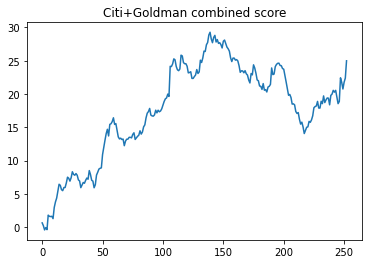

In [113]:
plt.title('Citi+Goldman combined score')
system_reports['d0_r'].cumsum().plot()
print(system_reports['d0_r'].sum())

31.601010572


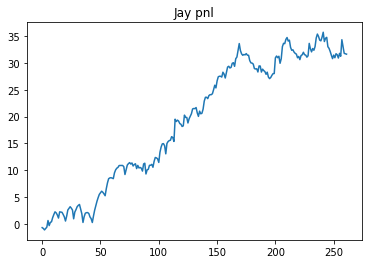

In [114]:
plt.title('Jay pnl')
jay_pnl['Realized R'].cumsum().plot()
print(jay_pnl['Realized R'].sum())

In [107]:
DL.toDB(system_reports, 'System reports (combined ranking).csv')

In [115]:
# 2. Combined scoring: all Citi
system_report_ind = []
for i, row in trade_record.iterrows():
    
    num_trade = row['No. of trades']
    (date, region, side) = i
    df = all_reports[all_reports['Broker'] == 'Citi']
    df = df[df['Date'] == date]
    df = df[df['exch_region'] == region]
    df = df[df['side'] == side]
    df = df.sort_values('d0_exp', ascending=False)
    
    system_report_ind.extend(df.iloc[:num_trade].index)

system_reports = all_reports.iloc[system_report_ind]
system_reports = system_reports.sort_values(['Date'], ascending=True).reset_index(drop=True)
system_reports

system_reports = get_pnl(system_reports)

19:35:27 Calculating pnl...
19:35:27 Row 0 CMDG.SI completed.


20.607718569013947


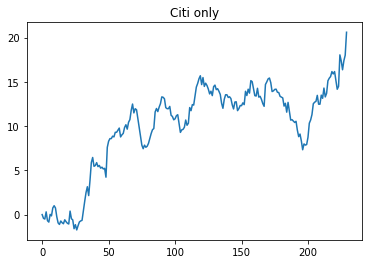

In [116]:
plt.title('Citi only')
system_reports['d0_r'].cumsum().plot()
print(system_reports['d0_r'].sum())

In [117]:
DL.toDB(system_reports, 'System reports (Citi only).csv')

In [118]:
# 3. Combined scoring: all Goldman
system_report_ind = []
for i, row in trade_record.iterrows():
    
    num_trade = row['No. of trades']
    (date, region, side) = i
    df = all_reports[all_reports['Broker'] == 'Goldman']
    df = df[df['Date'] == date]
    df = df[df['exch_region'] == region]
    df = df[df['side'] == side]
    df = df.sort_values('d0_exp', ascending=False)
    
    system_report_ind.extend(df.iloc[:num_trade].index)

system_reports = all_reports.iloc[system_report_ind]
system_reports = system_reports.sort_values(['Date'], ascending=True).reset_index(drop=True)
system_reports

system_reports = get_pnl(system_reports)

19:37:49 Calculating pnl...
19:37:49 Row 0 0880.HK completed.


13.993934812689341


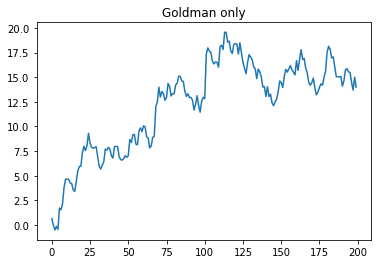

In [119]:
plt.title('Goldman only')
system_reports['d0_r'].cumsum().plot()
print(system_reports['d0_r'].sum())

In [120]:
DL.toDB(system_reports, 'System reports (Goldman only).csv')

In [ ]:
# 4. Combined scoring: random pick btw brokers
system_report_ind = []
for i, row in trade_record.iterrows():
    
    num_trade = row['No. of trades']
    (date, region, side) = i
#     df = all_reports[all_reports['Broker'] == 'Goldman']
    df = all_reports[all_reports['Date'] == date]
    df = df[df['exch_region'] == region]
    df = df[df['side'] == side]
    df = df.sort_values('d0_exp', ascending=False)
    
    system_report_ind.extend(df.iloc[:num_trade].index)

system_reports = all_reports.iloc[system_report_ind]
system_reports = system_reports.sort_values(['Date'], ascending=True).reset_index(drop=True)
system_reports

system_reports = get_pnl(system_reports)

In [134]:
jay_pnl['Date'] = jay_pnl['Entry Date']
jay_pnl['d0_date'] = jay_pnl['Entry Date']
jay_pnl['d1_r'] = jay_pnl['d0_r']
jay_pnl['d2_r'] = jay_pnl['d0_r']
jay_pnl['pm_region'] = jay_pnl['exch_region']

In [135]:
DL.toDB(jay_pnl, 'Backtest/jay pnl.csv')

In [124]:
from Backtest import visual

In [136]:
vis = visual('jay pnl')
vis.visual_job()

19:50:39 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/jay pnl.csv
side 
short    137
long     125
dtype: int64
 Sum of d0_r 31.601010572
 Sum of d1_r 31.601010572
 Sum of d2_r 31.601010572
Africa Sum of d0_r -1.62773019
Africa Sum of d1_r -1.62773019
Africa Sum of d2_r -1.62773019
Americas Sum of d0_r -5.255439285
Americas Sum of d1_r -5.255439285
Americas Sum of d2_r -5.255439285
Asia Sum of d0_r 31.33883919
Asia Sum of d1_r 31.33883919
Asia Sum of d2_r 31.33883919
Europe Sum of d0_r 5.387757225
Europe Sum of d1_r 5.387757225
Europe Sum of d2_r 5.387757225
Africa Sum of d0_r -1.62773019
Africa Sum of d1_r -1.62773019
Africa Sum of d2_r -1.62773019
Americas Sum of d0_r -5.255439285
Americas Sum of d1_r -5.255439285
Americas Sum of d2_r -5.255439285
Asia Sum of d0_r 31.33883919
Asia Sum of d1_r 31.33883919
Asia Sum of d2_r 31.33883919
Europe Sum of d0_r 5.387757225
Europe Sum of d1_r 5.387757225
Europe Sum of d2_r 5.387757225
Long trades hit ratio 0.51

2022-05-11 19:50:41,207 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,211 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,212 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,216 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,409 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,413 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,414 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,418 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,799 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,805 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:50:41,806 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11

In [138]:
vis = visual('System reports (combined ranking)')
vis.visual_job()

19:52:56 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi/Database\Backtest/System reports (combined ranking).csv
side 
short    129
long     124
dtype: int64
 Sum of d0_r 24.995585717
 Sum of d1_r 44.754297505000004
 Sum of d2_r 44.684713046
Americas Sum of d0_r -0.8814829359999996
Americas Sum of d1_r -4.010450509
Americas Sum of d2_r -5.030764362999999
Asia Sum of d0_r 15.711039216
Asia Sum of d1_r 35.414455182999994
Asia Sum of d2_r 38.393618137999994
Europe Sum of d0_r 10.166029436999999
Europe Sum of d1_r 13.350292830999997
Europe Sum of d2_r 11.321859271000001
Americas Sum of d0_r -0.8814829359999996
Americas Sum of d1_r -4.010450509
Americas Sum of d2_r -5.030764362999999
Asia Sum of d0_r 15.711039216
Asia Sum of d1_r 35.414455182999994
Asia Sum of d2_r 38.393618137999994
Europe Sum of d0_r 10.166029436999999
Europe Sum of d1_r 13.350292830999997
Europe Sum of d2_r 11.321859271000001
Long trades hit ratio 0.5161
Short trades hit ratio 0.5349
       Hit ratio  Loss 

2022-05-11 19:52:57,643 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,645 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,646 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,647 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,659 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,879 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,881 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,882 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,883 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:57,897 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11 19:52:58,386 P[30372] [MainThread 25868] posx and posy should be finite values
2022-05-11